In [1]:
import os
import tempfile
from typing import Dict, Optional
from glob import glob

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import EuroSATDataModule
from torchgeo.transforms import AugmentationSequential, indices
from torchgeo.trainers import ClassificationTask
from torchgeo.models import ResNet18_Weights

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

seed_everything(543)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Global seed set to 543


cuda


Train on all bands - experiment with model params, pretrained weights etc

In [2]:
if device == "cuda":
    batch_size = 64
    num_workers = 8
elif device ==  "cpu":
    batch_size = 16
    num_workers = 0
else:
    print("unknown device!")

datamodule = EuroSATDataModule(
    batch_size=batch_size, 
    root="data", 
    num_workers=num_workers, 
    download=True,
)

Do some validation on the train set

In [3]:
datamodule.prepare_data()
datamodule.setup('fit')
len(datamodule.train_dataset)

16200

In [4]:
datamodule.train_dataset.bands

('B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B08A',
 'B09',
 'B10',
 'B11',
 'B12')

In [5]:
datamodule.train_dataset[0]['image'].shape

torch.Size([13, 64, 64])

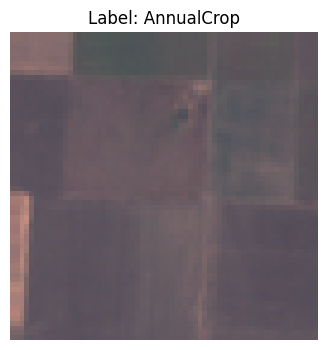

In [6]:
sample = datamodule.train_dataset[0]
fig = datamodule.train_dataset.plot(sample)

## Experiment
Experiment with the model and pretrained weights -> https://torchgeo.readthedocs.io/en/stable/tutorials/pretrained_weights.html

In [7]:
model = ClassificationTask(
    model="resnet18",
    weights=True, # standard Imagenet
    # weights=ResNet18_Weights.SENTINEL2_ALL_MOCO, # or try sentinel 2 all bands
    # weights=ResNet18_Weights.SENTINEL2_RGB_MOCO, # or try sentinel 2 rgb bands
    num_classes=10,
    in_channels=13,
    loss="ce", 
    patience=10
)

In [8]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

# tb_logger = TensorBoardLogger("tensorboard_logs", name="eurosat")
wandb_logger = WandbLogger(
    project="eurosat", 
    name="SENTINEL2_ALL_MOCO", 
    # log_model=True, 
    save_dir = "wandb_logs"
)

# wandb_logger.watch(model, log="all")

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=wandb_logger,
    min_epochs=5,
    max_epochs=25,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: robmarkcole. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | ResNet           | 11.2 M
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [10]:
trainer.test(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │     0.963333010673523     │
│       test_F1Score        │    0.9649999737739563     │
│     test_JaccardIndex     │    0.9315980672836304     │
│   test_OverallAccuracy    │    0.9649999737739563     │
│         test_loss         │    0.12457782030105591    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.12457782030105591,
  'test_AverageAccuracy': 0.963333010673523,
  'test_F1Score': 0.9649999737739563,
  'test_JaccardIndex': 0.9315980672836304,
  'test_OverallAccuracy': 0.9649999737739563}]

In [11]:
wandb_logger.experiment.finish()

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_AverageAccuracy,▁
test_F1Score,▁
test_JaccardIndex,▁
test_OverallAccuracy,▁
test_loss,▁
train_AverageAccuracy,▂▃▁▆▄▇▇▇▅█▆▇▇▇▇▇▇█▆█▆▇█▇▇██▇███▇███▇█▇▇▆
train_F1Score,▄▃▁▅▄▆▆▆▅█▅▇▇▇▇▆▇█▇█▅▇█▇▇██▇███▇███▇█▇▇▆
train_JaccardIndex,▄▃▁▆▅▆▆▇▅█▆▇▇▇▇▇▇█▆█▅▇█▇▇██▇███▇███▇█▇▇▅
train_OverallAccuracy,▄▃▁▅▄▆▆▆▅█▅▇▇▇▇▆▇█▇█▅▇█▇▇██▇███▇███▇█▇▇▆
train_loss,▅▆█▆▄▄▃▂▅▁▄▂▂▂▁▂▂▁▂▁▄▂▁▂▁▁▂▂▁▂▁▃▁▁▁▁▁▁▂▃


In [12]:
wandb_logger.experiment

The model checkpoints are local:

In [13]:

glob("wandb_logs/eurosat/*/checkpoints/*.ckpt")

['wandb_logs/eurosat/3r48sn1a/checkpoints/epoch=6-step=1778.ckpt',
 'wandb_logs/eurosat/1jqhby56/checkpoints/epoch=11-step=3048.ckpt',
 'wandb_logs/eurosat/goxd835d/checkpoints/epoch=8-step=2286.ckpt']

But we can also access them from Wandb!